# **Fraud (Overbilling) Detection in Healthcare Using Machine Learning Methods**
### **Data Science final project**


## **Case study in Jupyter Notebook**



## **I. Data preprocessing**

**1. Uploading dataset, initial data analysis, filling NAN values.**

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
%cd /content/gdrive/My Drive/Diploma/My notebooks

/content/gdrive/My Drive/Diploma/My notebooks


In [54]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_excel('dataset_dip.xlsx', parse_dates=True)  


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID записи      1069 non-null   int64         
 1   Дата приема    1069 non-null   datetime64[ns]
 2   Дата записи    1069 non-null   datetime64[ns]
 3   Способ записи  1069 non-null   object        
 4   Телефон        1069 non-null   object        
 5   Врач           984 non-null    object        
 6   Специальность  1067 non-null   object        
 7   Статус_выст    1030 non-null   object        
 8   Label          1069 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 75.3+ KB


Phone number formatting 

In [56]:
df['Телефон'] = df['Телефон'].str.replace(r'\D+', '', regex=True)

Counting NaNs

In [57]:
df[df.columns[df.isnull().any()]].isnull().sum()

Врач             85
Специальность     2
Статус_выст      39
dtype: int64

Filling NaNs

In [58]:
df = df.fillna({'Статус_выст': 'Отклонённые', 'Врач': 'Не определен', 'Специальность': 'Не определен'})
df.isnull().sum()

ID записи        0
Дата приема      0
Дата записи      0
Способ записи    0
Телефон          0
Врач             0
Специальность    0
Статус_выст      0
Label            0
dtype: int64

**2.Feature engineering**
<br>(based on the agreement conditions between the Clinic and the Aggregator.)

**2.1** We are making a feature called **'Occurence_tel'** - that is the frequency count of a phone number in the dataset, this feature will devide all patients into two categories (those who came ones and those who came multiple times). 

In [59]:
df['Occurence_tel'] = df['Телефон'].map(df['Телефон'].value_counts())

**We are creating a feature called 'differ_months',**
<br>it's a time difference in months between the visits.

In [60]:
df['differ_months'] = df['Дата приема'][df['Occurence_tel']>0].dt.to_period('M').diff()
df['differ_months'] = df['differ_months'].fillna(0)
df['differ_months'] = df['differ_months'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
df = df.fillna(0)

**2.2 Another new feature called 'Diagn'**: 
<br>we mark the doctors who both consult and perform diagnostic procedures.

In [61]:
names = {'Симонова Елена Федоровна' : 'yes', 'Архипенко Сергей Анатольевич' : 'yes', 'Павлова Лариса Аркадьевна':'yes' }
df["Diagn"] = df["Врач"].map(names).fillna('no')

**2.3 And one more feature 'delta'**
<br>that is the time difference between the scheduling and the visit.

In [62]:
df['delta'] = ((df['Дата приема'] - df['Дата записи'])).dt.days
df = df.fillna(0)

**2.4** We drop the columns that are not needed for building the model.

In [63]:
df1 = df.drop(columns=['ID записи','Дата приема', 'Телефон', 'Дата записи']) 

**3. Label encoding of categorial values.**

In [64]:
from sklearn.preprocessing import LabelEncoder

cols = ['Способ записи', 'Врач', 'Специальность', 'Статус_выст', 'Diagn']
df1[cols] = df1[cols].apply(LabelEncoder().fit_transform)
df1[:2]

,Способ записи,Врач,Специальность,Статус_выст,Label,Occurence_tel,differ_months,Diagn,delta
0,1,11,15,0,0,1,0.0,1,0
1,1,9,12,0,0,1,0.0,0,0


**4. Class distribution in the dataset.**

In [65]:
len(df[df['Label']==1]) 

42

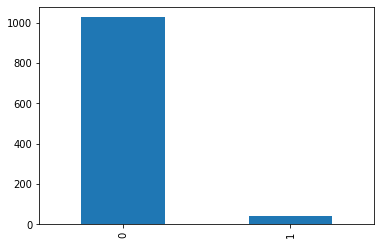

In [66]:
df1['Label'].value_counts(normalize=True)
df1['Label'].value_counts().plot(kind='bar')

In [67]:
df3 = df1.drop('Label', axis=1)
df4 = df1['Label']
X = df3
y = df4

**5. Data scaling**

In [68]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_fit = sc.fit(X)
X_std = X_fit.transform(X)
X = X_std

In [69]:
X.shape, y.shape

((1069, 8), (1069,))

In [70]:
X[:2]

array([[ 0.7335731 ,  1.16743119,  1.72458522, -0.28055013, -0.46985253,
        -0.11929585,  1.76395535, -0.56844686],
       [ 0.7335731 ,  0.55114282,  0.93560593, -0.28055013, -0.46985253,
        -0.11929585, -0.56690777, -0.56844686]])

# **II. Preliminary assessment of 11 models with k-fold cross-validation (k=10).**

**Models to be assessed:** <br>
**1) LogisticRegression** <br>
**2) Catboost** <br>
**3) naive_bayes** <br>
**4) BalancedRandomForestClassifier** <br>
**5) BaggingClassifier** <br>
**6) XGBClassifier** <br>
**7) RandomForestClassifier** <br>
**8) GradientBoostingClassifier** <br>
**9) KNeighborsClassifier** <br>
**10) DecisionTreeClassifier** <br>
**11) SVM** <br>

In [71]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot

>lr 0.766 (0.141)
>knn 0.612 (0.106)
>cart 0.542 (0.124)
>svc 0.494 (0.142)
>bayes 0.724 (0.128)
>cat 0.749 (0.134)
>brfc 0.758 (0.139)
>bag 0.626 (0.130)
>rfc 0.722 (0.135)
>xgb 0.775 (0.137)
>svm 0.543 (0.168)


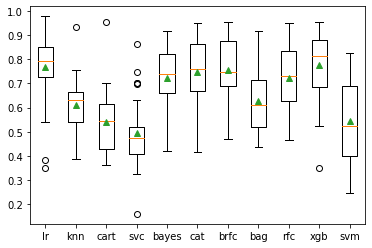

In [73]:
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svc'] = SVC()
    models['bayes'] = GaussianNB()
    models['cat'] = CatBoostClassifier()
    models['brfc'] = BalancedRandomForestClassifier()
    models['bag'] = BaggingClassifier()
    models['rfc'] = RandomForestClassifier()
    models['xgb'] = XGBClassifier()
    models['svm'] = svm.SVC(kernel='linear')
    return models

def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1, error_score='raise')
	return scores

models = get_models()

results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**We select 5 top ones for further work:** <br>
**1) LogisticRegression** <br>
**2) XGBClassifier** <br>
**3) Catboost** <br>
**4) BalancedRandomForestClassifier** <br>
**5) Naive Bayes**

# **III. Tuning of the chosen models**

**1. Logistic regression with SMOTE oversampling, L2 regularization and the calculated threshold.**

In [74]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Применяем SMOTE oversampling к обучающей выборке
sm = SMOTE(random_state=2)

X_res, y_res = sm.fit_resample(X_train, y_train)
print('After OverSampling, the shape of X: {}'.format(X_res.shape))
print('After OverSampling, the shape of y: {} \n'.format(y_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))


After OverSampling, the shape of X: (1648, 8)
After OverSampling, the shape of y: (1648,) 

After OverSampling, counts of label '1': 824
After OverSampling, counts of label '0': 824


Best Threshold=0.528238, G-Mean=0.771


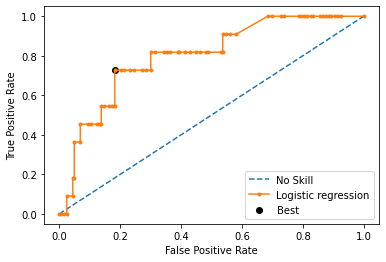

Accuracy: 0.804
Roc_auc: 0.682
F1: 0.853
Recall: 0.545
Precision: 0.928
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       203
           1       0.14      0.55      0.22        11

    accuracy                           0.80       214
   macro avg       0.56      0.68      0.55       214
weighted avg       0.93      0.80      0.85       214

[[166  37]
 [  5   6]]


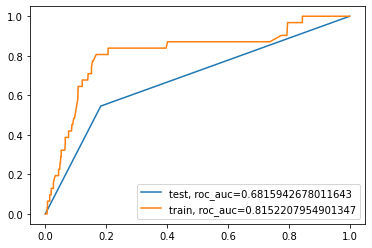

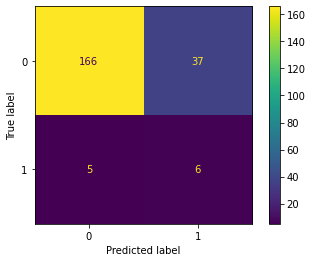

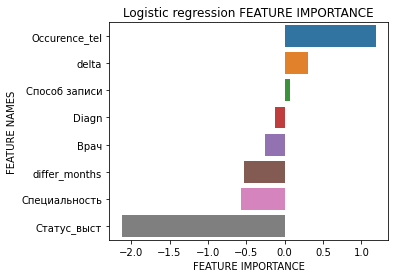

In [75]:
clf = LogisticRegression(solver='lbfgs', random_state=42, max_iter=10000) 
estimator_name='Logistic regression'
clf.fit(X_res, y_res)

# We create a function to calculate and plot roc curve with an optimal threshold
def threshold_roc(model):
    yhat = model.predict_proba(X_test)[:, 1] 
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_test, yhat)
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label=estimator_name)
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()
    return thresholds[ix]

# We create a function to plot confusion matrix, roc-auc and classification report
def conf_roc_rep(model, estimator_name): 

    plt.figure(0).clf()
    y_pred = model.predict_proba(X_test)[:, 1] 
    y_pred = np.where(y_pred>round(threshold_roc(model), 6), 1, 0)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,tpr,label="test, roc_auc="+str(roc_auc))
 
    y_pred_tr = model.predict_proba(X_train)[:, 1] 
    fpr_tr, tpr_tr, thresholds_tr = metrics.roc_curve(y_train, y_pred_tr)
    roc_auc_tr = metrics.auc(fpr_tr, tpr_tr)
    plt.plot(fpr_tr,tpr_tr,label="train, roc_auc="+str(roc_auc_tr))

    plt.legend(loc=0)
    print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
    print('Roc_auc: %.3f' % roc_auc_score(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_test, y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_test, y_pred, average='binary'))
    print('Precision: %.3f' %  precision_score(y_test, y_pred, average='weighted'))
    print(classification_report(y_test, y_pred)) 
    print(confusion_matrix(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=clf.classes_)
    disp.plot()
    plt.show()

# Function for feature importances
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(5,4))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

conf_roc_rep(clf, 'Logistic regression')
plot_feature_importance(clf.coef_[0],df3.columns,'Logistic regression')

**2. Catboost with SMOTE oversampling and threshold.**

Best Threshold=0.039235, G-Mean=0.772


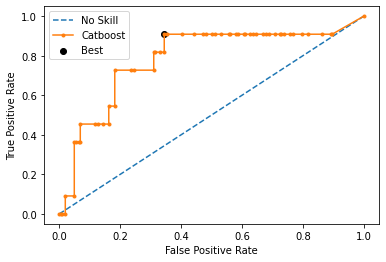

Accuracy: 0.668
Roc_auc: 0.782
F1: 0.760
Recall: 0.909
Precision: 0.948
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       203
           1       0.12      0.91      0.22        11

    accuracy                           0.67       214
   macro avg       0.56      0.78      0.50       214
weighted avg       0.95      0.67      0.76       214

[[133  70]
 [  1  10]]


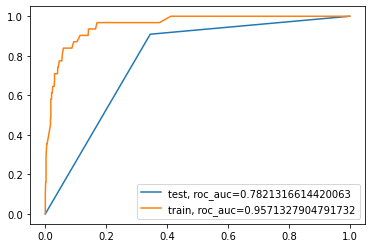

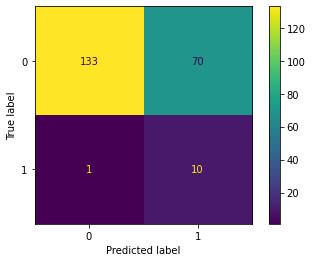

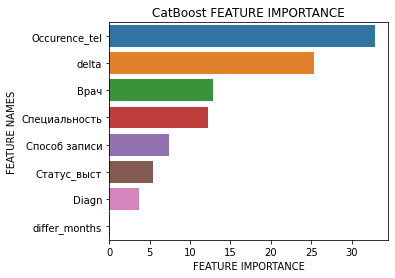

In [76]:
model_CB = CatBoostClassifier(iterations=150,
                             depth=12, 
                             eval_metric='AUC',
                             random_seed = 2018,
                             od_type='Iter',
                             metric_period = 1,
                             od_wait=100, silent=True)
model_CB.fit(X_res,y_res)
estimator_name='Catboost'

conf_roc_rep(model_CB, 'Catboost')
plot_feature_importance(model_CB.get_feature_importance(), df3.columns,'CatBoost')

**3. BalancedRandomForestClassifier (no sampling, with the threshold).**

Best Threshold=0.550667, G-Mean=0.773


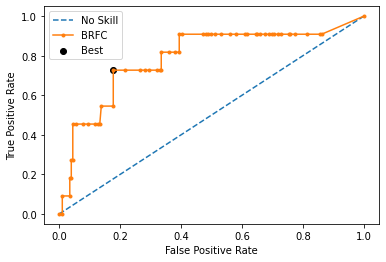

Accuracy: 0.808
Roc_auc: 0.684
F1: 0.857
Recall: 0.545
Precision: 0.928
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       203
           1       0.14      0.55      0.23        11

    accuracy                           0.81       214
   macro avg       0.56      0.68      0.56       214
weighted avg       0.93      0.81      0.86       214

[[167  36]
 [  5   6]]


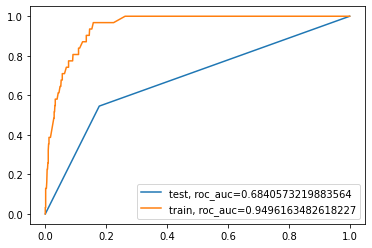

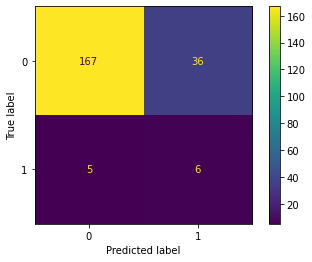

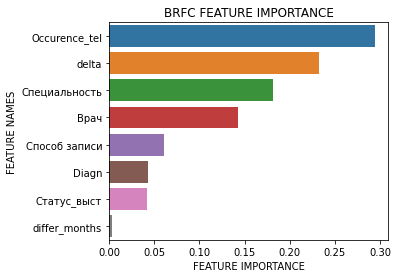

In [77]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
brf.fit(X_train, y_train)
estimator_name='BRFC'

conf_roc_rep(brf, 'BRFC')
plot_feature_importance(brf.feature_importances_, df3.columns,'BRFC')

**4. Naive Bayes with SMOTE and the threshold.**

Best Threshold=0.516053, G-Mean=0.769


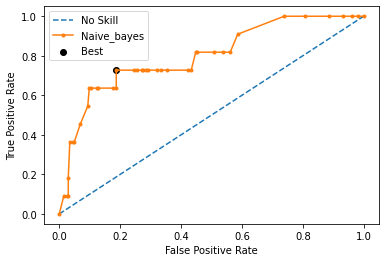

Accuracy: 0.808
Roc_auc: 0.770
F1: 0.858
Recall: 0.727
Precision: 0.941
              precision    recall  f1-score   support

           0       0.98      0.81      0.89       203
           1       0.17      0.73      0.28        11

    accuracy                           0.81       214
   macro avg       0.58      0.77      0.59       214
weighted avg       0.94      0.81      0.86       214

[[165  38]
 [  3   8]]


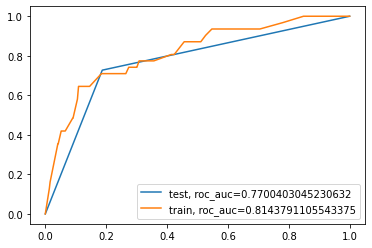

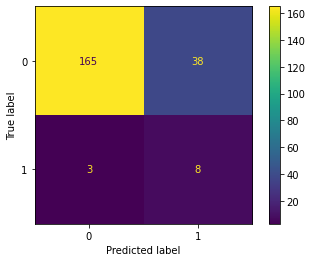

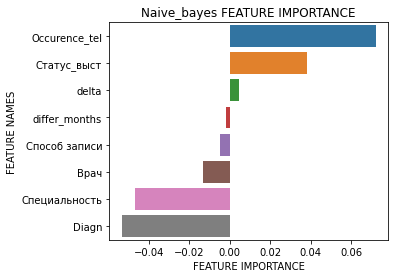

In [78]:
from sklearn.inspection import permutation_importance
from sklearn import naive_bayes

NB = naive_bayes.BernoulliNB()
NB.fit(X_res, y_res)

estimator_name='Naive_bayes'
conf_roc_rep(NB, 'Naive_bayes')
imps = permutation_importance(NB, X_test, y_test)
plot_feature_importance(imps.importances_mean, df3.columns,'Naive_bayes')

**5. XGBoost with SMOTE sampling and the threshold.**

Best Threshold=0.211204, G-Mean=0.859


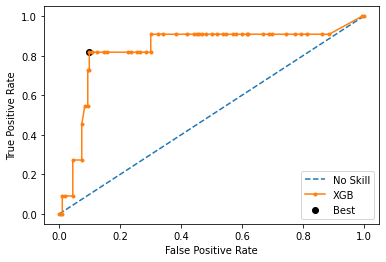

Accuracy: 0.897
Roc_auc: 0.860
F1: 0.918
Recall: 0.818
Precision: 0.954
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       203
           1       0.31      0.82      0.45        11

    accuracy                           0.90       214
   macro avg       0.65      0.86      0.70       214
weighted avg       0.95      0.90      0.92       214

[[183  20]
 [  2   9]]


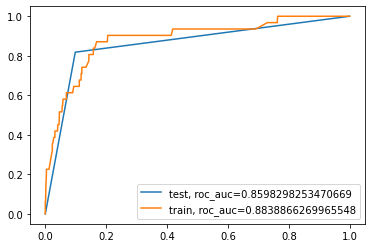

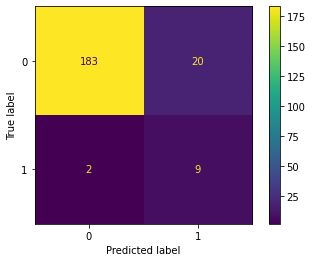

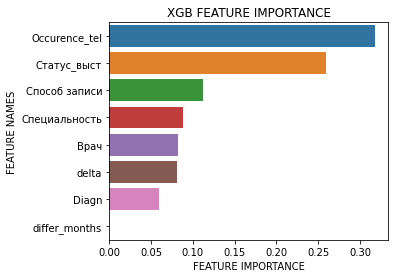

In [79]:
xgb = XGBClassifier(scale_pos_weight=1, scoring='roc_auc',random_state = 42, n_jobs = -1, subsample=0.7)
xgb.fit(X_res, y_res)
estimator_name='XGB'
conf_roc_rep(xgb, 'XGB')
plot_feature_importance(xgb.feature_importances_, df3.columns,'XGB')

**XGBoost model - Feature Importance Computed with SHAP Values**

In [80]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 14.2 MB/s eta 0:00:00


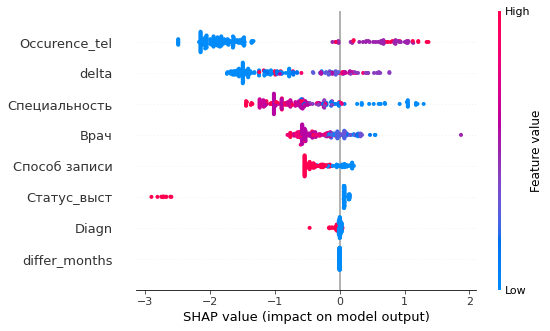

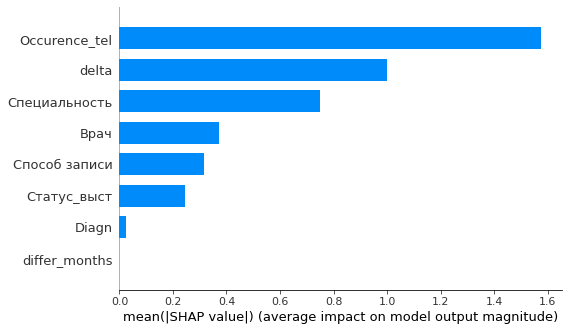

In [81]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names= df3.columns)
shap.summary_plot(shap_values, X_test, feature_names= df3.columns, plot_type="bar")
#shap.dependence_plot('differ_months', shap_values, X_test, feature_names= df3.columns)

**Feature differ_months turned out to be irrelevant for the XGBoost model. Lets have a look at the result without this feature.**

---



Best Threshold=0.211204, G-Mean=0.859


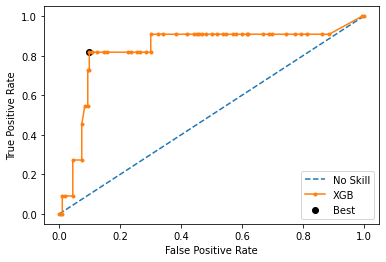

Accuracy: 0.897
Roc_auc: 0.860
F1: 0.918
Recall: 0.818
Precision: 0.954
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       203
           1       0.31      0.82      0.45        11

    accuracy                           0.90       214
   macro avg       0.65      0.86      0.70       214
weighted avg       0.95      0.90      0.92       214

[[183  20]
 [  2   9]]


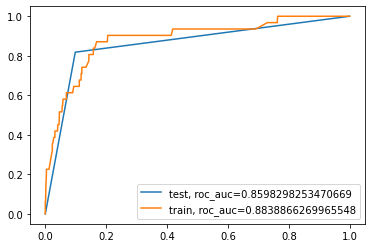

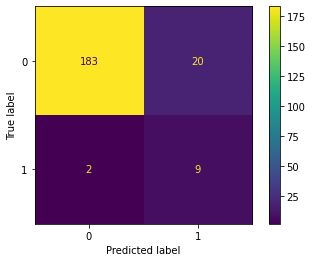

In [82]:
X = df3.drop('differ_months', axis=1)
X_fit = sc.fit(X)
X_std = X_fit.transform(X)
X = X_std

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# we apply SMOTE oversampling to the train dataset
sm = SMOTE(random_state=2)

X_res, y_res = sm.fit_resample(X_train, y_train)

xgb = XGBClassifier(scale_pos_weight=1, scoring='roc_auc',random_state = 42, n_jobs = -1, subsample=0.7)
xgb.fit(X_res, y_res)
estimator_name='XGB'
conf_roc_rep(xgb, 'XGB')


**We can see that the quality remained the same, so we can get rid of this feature.**

**For the XGBoost model we will plot a log-loss curve for train and test datasets.**

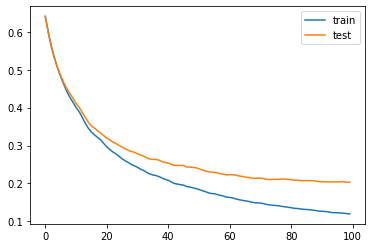

In [83]:
evalset = [(X_res, y_res), (X_test,y_test)]
xgb.fit(X_res, y_res, eval_metric='logloss', eval_set=evalset, verbose = 0) #verbose = 1
results = xgb.evals_result()
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')

pyplot.legend()
pyplot.show()

**Summary: The XGBoost model with SMOTE sampling and the calculated threshold showed the best result (AUC=0,86): 82% of the fraud cases were identified correctly (18% of the fraud were not identified).**